<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Métodos Bayesianos</div><br>
    <div style="font-size: x-large; color:gray">Practica: Mixtura de Gausianas</div><br>
    <div style="font-size: large; color:#FF0000">Marcos Vázquez Martín y Adrián Rubio Pintado </div><br></div><hr>
</div>

In [ ]:
%%html
<style>
    .qst {background-color: #b1cee3; padding:10px; border-radius: 5px; border: solid 2px #5D8AA8;}
    .qst:before {font-weight: bold; content:"Ejercicio"; display: block; margin: 0px 10px 10px 10px;}
           
    h1, h2, h3 {color: #5D8AA8;}
    .text_cell_render p {text-align: justify; text-justify: inter-word;}
</style>

Se debe implementar un modelo de mixtura de gausianas mediante el algoritmo de esperanza-maximización (EM). Este modelo se utiliza para estimar una densidad de probabilidad a partir de $N$ puntos en $D$ dimensiones, $\mathcal{D}=\{\mathbf{x}_i\}_{i=1}^N$, basado en $K$ gausianas

$$    p(\mathbf{X}) = \sum_{k=1}^K \pi_k \mathcal{N} (\mathbf{X}; \mathbf{\mu_k}, \Sigma_k) $$

donde $\pi_k$ es la probabilidad de observar un punto en la gausiana $k$ con $\sum_{k=1}^K \pi_k = 1$ y donde $\mathbf{\mu_k}, \Sigma_k$ son la media y la matriz de covarianza respectivamente de la gausiana $k$.

Para resolver este problema vamos a plantearlo con la siguiente red de bayes:

![gmm.svg](attachment:gmm.svg)

donde la variable $\mathbf{Z}$ indica la gausiana a la que pertenece cada dato codificado como 1-en-K, esto es, $\mathbf{Z}$ es un vector binario de K componentes donde una y solo una vale 1 y el resto 0. Si $z_{ik}=1$ entonces el ejemplo $\mathbf{X}_i$ pertence a la gausiana $k$. Donde 

$$ p(\mathbf{X}) = \sum_{k=1}^K p(z_k=1) p(\mathbf{X}|z_k=1) $$

donde $p(z_k=1)=\pi_k$ y $p(\mathbf{X}|z_k=1) =  \mathcal{N} (\mathbf{X}; \mathbf{\mu_k}, \Sigma_k) $.

Para aplicar el algoritmo EM tenemos que la variable no observada es la $\mathbf{Z}$ para todos los ejemplos, por lo que en el paso E debemos estimar la probabilidad de observar 1 para cada uno de las $K$ entradas en $Z$ para cada uno de los ejemplos en $\mathcal{D}$. 

En el **paso E**, estimaremos $D \times K$ valores de la siguiente forma:

<u>Paso E:</u>

$$ q_i(z_k=1) = \frac{p(z_k=1)p(\mathbf{X}|z_k=1)}{\sum_{k=1}^K p(z_k=1)p(\mathbf{X}|z_k=1)} $$

En el **paso M** lo que debemos hacer es estimar los parámetros del modelo a partir de los datos como se indica a continuación.

<u>Paso M:</u>

$$ \pi_k = \frac{1}{N} \sum_{i=1}^N q_i(z_k=1) $$

$$ \mathbf{\mu}_k = \frac{1}{\sum_{i=1}^N q_i(z_k=1)} \sum_{i=1}^N q_i(z_k=1) \mathbf{x}_i $$

$$ \Sigma_k = \frac{1}{\sum_{i=1}^N q_i(z_k=1)} \sum_{i=1}^N q_i(z_k=1) (\mathbf{x}_i - \mathbf{\mu}_k)(\mathbf{x}_i - \mathbf{\mu}_k)^T $$

Finalmente la log-verosimilitud de los datos la podemos escribir como

$$ ln p(\mathbf{X}|\pi, \mathbf{\mu}, \Sigma) = \sum_{i=1}^N ln \left[ \sum_{k=1}^K \pi_k \mathcal{N} (\mathbf{x}_i; \mathbf{\mu_k}, \Sigma_k)  \right]$$ 

## Problemas numéricos
En la implementación de este método surgen diversos problemas numéricos:
- La matriz de covarianza debe ser semi-definida positiva. Para garantizar que las estimaciones que tenemos de la matriz de covarianza lo cumplen, se puede añadir un valor pequeño de regularización a la diagonal de la matriz (~1e10-5).
- El cálculo de los valores de $q$ supone el cálculo de una gausiana y puede darse el caso de que para algún ejemplo y para todo $k$ el valor sea 0. Para evitar esto se puede sumar una cantidad muy pequeña siempre a todos los valores de $q$ antes de normalizar. Adicionalmente se recomienda calcular esta probailidad como log prob y luego utilizar la función `np.logsumexp` para normalizar en el espacio de logprobs. 
- Finalmente, para evitar problemas numéricos al invertir la matriz de covarianza, se recomienda usar la descomposición de Choleski esto es: <tt>covinv = scipy.linalg.cho_solve(scipy.linalg.cho_factor(covariaza), I)</tt>, donde <tt>I</tt> es la matriz identidad.

In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import scipy 
import matplotlib as mpl
%matplotlib inline

In [ ]:
import matplotlib.transforms as transforms

def make_ellipse(cov, mean, ax, n_std=3.0, **kwargs):
    """
        Adaptado de: https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
        
        En kwargs se pueden poner todo tipo de argumentos para dibujar la elipse. Por ejemplo
        para que la elipse sea naranja semitransparente con borde rojo sería:
            
            def make_ellipse(cov, mean, ax, n_std=3.0, facecolor='orange', edgecolor='red', alpha=0.5)
            
    """
    
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = mpl.patches.Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]

    # Calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    
    ellipse.set_transform(transf + ax.transData)
    
    color = kwargs['edgecolor'] if 'edgecolor' in kwargs else 'red'
    
    ax.scatter(mean_x, mean_y, marker='x', c=color)
    
    return ax.add_patch(ellipse)

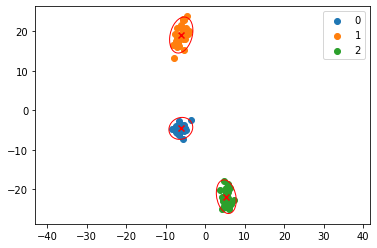

In [ ]:
# Generar datos
fig = plt.figure()
K=3
X, y = make_blobs(100, centers=K)

rotate = True
transformation = np.array([[1,0],[0,1]])

for y_k in np.unique(y):
    if rotate:
        transformation = np.array([[ (0.2+np.random.rand())*2,  0.5-np.random.rand()], 
                                   [0.5-np.random.rand(), (0.2+np.random.rand())*2]])
        X[y==y_k,:] = np.dot(X[y==y_k,:], transformation)
    plt.scatter(X[y==y_k,0], X[y==y_k,1],label=y_k)
    make_ellipse(transformation,np.mean(X[y==y_k,:],axis=0), ax=fig.axes[0],facecolor='none',edgecolor='red')
    
fig.axes[0].axis('equal')
plt.legend()

<div class="qst">

* Completa la clase `GMM` satisfaciendo los requisitos indicados anteriormente.

</div>

In [ ]:
from scipy.stats import multivariate_normal

class GMM:
    """ 
        Sugerencia para la organización del código
    """
    def __init__(self, K=3, n_iterations=100):  
        self.K = K
        self.n_iterations =  n_iterations
    
    def _initialize(self, X):
        self.means = np.random.uniform(low= min(X[:,0]), high=max(X[:,0]), size=(self.K,X.shape[1]))
        b = np.abs(np.amax(X, axis=0)) + np.abs(np.amin(X, axis=0))
        self.covs = np.broadcast_to(np.identity(X.shape[1])*b, (self.K, X.shape[1], X.shape[1])).copy()
        self.priors = np.full(self.K, 1/self.K)
        return self.priors, self.means, self.covs
        

    def _e_step(self, X, priors, means, covs):
        Q = np.zeros((X.shape[0], self.K))
        den = 0 
        covs_reg = self.covs + 1e-5*np.identity(X.shape[1])
        for i in range(self.K):
          prior = self.priors[i]
          pX = multivariate_normal(mean=self.means[i],cov=covs_reg[i]).pdf(X)
          Q[:,i] = pX * prior + np.full(pX.shape,1e-5)
        Q=Q/np.sum(Q, axis=1)[:, np.newaxis] 
        return Q
    
    def _m_step(self, X, Q):
        for i in range(self.K):
          # Calculo de prior
          self.priors[i] = np.sum(Q[:,i],axis=0) /  X.shape[0]
          # Calculo de mu
          self.means[i] = np.sum(X*Q[:,i].reshape(X.shape[0],1),axis=0)/np.sum(Q[:,i],axis=0)
          # Calculo covs
          self.covs[i, :, :] = (np.dot((X-self.means[i]).T, Q[:,i].reshape(X.shape[0],1)*(X-self.means[i]))/np.sum(Q[:,i],axis=0))
        return self.priors, self.means, self.covs
        
    def fit(self, X):
        log_likelihoods = []
        covs_list = []
        mean_list = []

        # Inicialización
        priors, means, covs = self._initialize(X)
        
        for i in range(self.n_iterations):
            #print("Iteration ", i)
            # Paso E
            Q = self._e_step(X, self.priors, self.means, self.covs)
            
            # Paso M
            priors, means, covs = self._m_step(X, Q)
            
            covs_list.append(list(self.covs.copy()))
            mean_list.append(list(self.means.copy()))

            #print(mean_list)
            log_likelihoods.append(np.log(np.sum([pi* multivariate_normal(mu,cov).pdf(X) for pi,mu,cov in zip(priors,means,covs)])))
        return log_likelihoods, self.priors,  self.means,  self.covs, covs_list, mean_list

In [ ]:
gmm = GMM()
likehood, prior, mean, covs, covs_list, mean_list = gmm.fit(X)

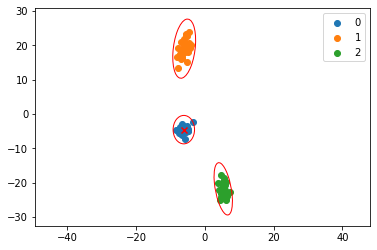

In [ ]:
# Generar datos
fig = plt.figure()

for y_k in np.unique(y):
    plt.scatter(X[y==y_k,0], X[y==y_k,1],label=y_k)
    make_ellipse(covs_list[-1][y_k], mean_list[-1][y_k], ax=fig.axes[0],facecolor='none',edgecolor='red')
    
fig.axes[0].axis('equal')
plt.legend()

<div class="qst">

* Se deben **visualizar** los resultados obtenidos. Al menos se deben mostrar las covarianzas y medias finales estimadas (usando `make_ellipse`) y cómo ha evolucionado la log-verosimilitud de los datos.

</div>

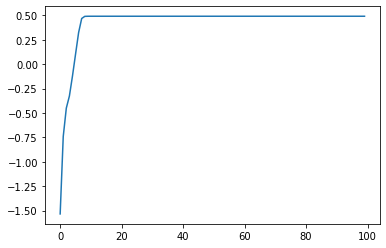

In [ ]:
plt.plot(likehood)

Vemos como el algoritmo converge a partir de cierto número de iteraciones.

In [ ]:
gmm = GMM()
likehood, prior, mean, covs, covs_list, mean_list = gmm.fit(X)

Pintamos una animación de la evolución del aloritmo:

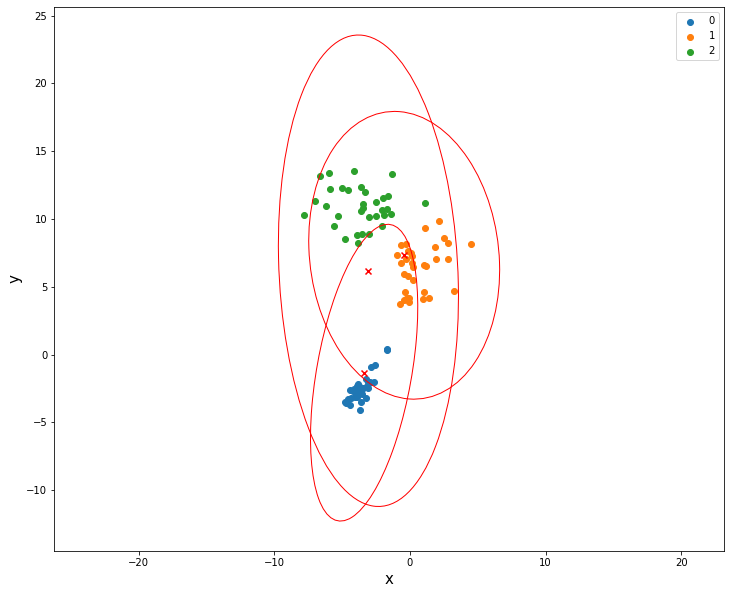

In [ ]:
from random import randint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import rc
from sympy import symbols, Eq, solve 
import sympy as sm
import warnings


warnings.filterwarnings("ignore")

rc('animation', html='html5')


# create the figure and axes objects
fig, ax = plt.subplots(figsize=(12,10))

plt.ylim([-35,5])


def animate(i):
    ax.clear()
    for y_k in np.unique(y):
      plt.scatter(X[y==y_k,0], X[y==y_k,1],label=y_k)
      make_ellipse(covs_list[i][y_k],mean_list[i][y_k], ax=fig.axes[0],facecolor='none',edgecolor='red')
    
    fig.axes[0].axis('equal')
    plt.legend()

    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('y', fontsize=15)

ani = FuncAnimation(fig, animate, frames=100, interval=400, repeat=True)
ani

Medias finales obtenidas:

In [ ]:
mean

array([[-3.56512091, -2.42035696],
       [-3.64082406, 10.82254227],
       [ 0.7188353 ,  6.44794852]])

Covarianzas finales Obtenidas:

In [ ]:
 covs

array([[[ 0.61709099,  0.70262423],
        [ 0.70262423,  1.48842451]],

       [[ 3.74180273, -0.57936349],
        [-0.57936349,  2.29414443]],

       [[ 1.79973275,  0.74962033],
        [ 0.74962033,  3.29662502]]])